<a href="https://colab.research.google.com/github/creepereye1204/HomeWork/blob/main/HomeWork/Restnet50(rl%3DAuto%2Cresult%3D0.28%2Cepoch%3D6%2COptim%3DSGD).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install kaggle --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import tensorflow as tf

In [ ]:
from google.colab import files
files.upload()

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c plant-pathology-2020-fgvc7

In [7]:
import os
os.mkdir('/content/train')


In [ ]:
!unzip /content/plant-pathology-2020-fgvc7.zip -d /content/

In [9]:
import pandas as pd

In [10]:
train=pd.read_csv('/content/train.csv')

In [11]:
category=['healthy','multiple_diseases','rust','scab']

In [12]:
for dir in category:
  os.makedirs('/content/train/'+dir)

In [13]:
train.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


In [14]:
import numpy as np

In [15]:
TRAIN=pd.DataFrame(columns=['image','labels'])
for s in train.values:
  idx,label=s[0],s[1:]
  n=np.argmax(label)
  n=category[n]
  cols= ['image','labels']	
  
  add_row = [[idx,n]]	

  row_df = pd.DataFrame(data = add_row, columns = cols)	
                          
  TRAIN= pd.concat([TRAIN, row_df], ignore_index = True)
    

In [16]:
TRAIN

,image,labels
0,Train_0,scab
1,Train_1,multiple_diseases
2,Train_2,healthy
3,Train_3,rust
4,Train_4,healthy
...,...,...
1816,Train_1816,scab
1817,Train_1817,healthy
1818,Train_1818,healthy
1819,Train_1819,rust


In [17]:
import shutil
def move(data,where):
  path='/content/images/'
  for name,label in data.values:
      shutil.move(path+name+".jpg","/content/"+where+"/"+label+'/'+name+'.jpg')

In [18]:
move(TRAIN,"train")

In [19]:
TRAIN['labels'].value_counts()

rust                 622
scab                 592
healthy              516
multiple_diseases     91
Name: labels, dtype: int64

In [20]:
import matplotlib.pyplot as plt


<Axes: >

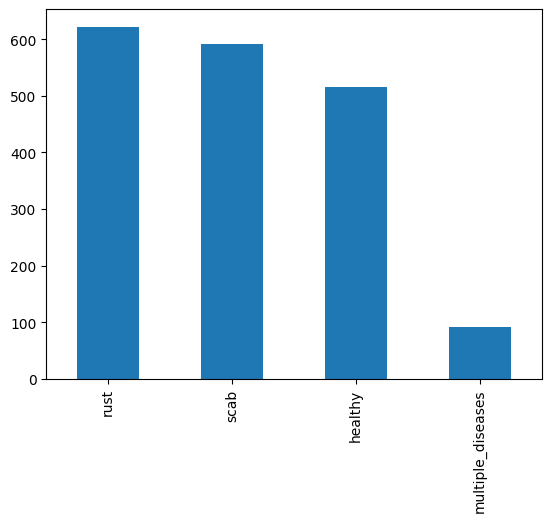

In [21]:
TRAIN['labels'].value_counts().plot(kind='bar')

In [22]:
len(train)

1821

In [23]:
batch=32
num_epochs = 20
img_height=325
img_width=325
dir="/content/train"

In [24]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch)

Found 1821 files belonging to 4 classes.
Using 1457 files for training.


In [25]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch)

Found 1821 files belonging to 4 classes.
Using 364 files for validation.


In [26]:
class_names = train_ds.class_names
print(class_names)

['healthy', 'multiple_diseases', 'rust', 'scab']


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [28]:
train_ds

<_BatchDataset element_spec=(TensorSpec(shape=(None, 325, 325, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [50]:
from tensorflow.keras.applications import DenseNet121,ResNet50

In [30]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

In [37]:
import tensorflow.keras.layers as layers

In [63]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

base_model = keras.applications.ResNet50(
    weights='imagenet',
    input_shape=(325, 325, 3),
    include_top=False)

# Set the base_model's layers as non-trainable
for layer in base_model.layers:
    layer.trainable = False

# Add the custom layers for 4-class classification
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(4, activation='softmax')(x)

# Create the final model
model = keras.Model(inputs=base_model.input, outputs=outputs)

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])


In [71]:
import tensorflow as tf
with tf.device("/device:GPU:0"):
  from tensorflow.keras.datasets import cifar10
  from tensorflow.keras.layers import Dense,Flatten
  from tensorflow.keras.models import Model
  from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
  from tensorflow.keras.callbacks import EarlyStopping



  base_model =ResNet50(weights='imagenet', include_top=False,input_shape=(325,325,3))

  x=base_model.output
  x=Flatten()(x)
  predictions=Dense(4,activation='softmax')(x)

  model=Model(inputs=base_model.input,outputs=predictions)


      
  model.compile(optimizer='SGD',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

  early_stopping =EarlyStopping(monitor='val_loss',patience=3,verbose=1)

  history=model.fit(train_ds,batch_size=64, epochs=10, validation_data=test_ds,callbacks=[early_stopping])

  score=model.evaluate(test_ds,verbose=0)
  print("Test loss:",score[0])
  print("Test accuracy:",score[1])

Epoch 1/10
46/46 [==============================] - 62s 928ms/step - loss: 13.7836 - accuracy: 0.5882 - val_loss: 5.1738 - val_accuracy: 0.2885
Epoch 2/10
46/46 [==============================] - 38s 787ms/step - loss: 0.7779 - accuracy: 0.8058 - val_loss: 4.2357 - val_accuracy: 0.2885
Epoch 3/10
46/46 [==============================] - 39s 788ms/step - loss: 0.2694 - accuracy: 0.9231 - val_loss: 3.4890 - val_accuracy: 0.2885
Epoch 4/10
46/46 [==============================] - 39s 778ms/step - loss: 0.0771 - accuracy: 0.9801 - val_loss: 4.8966 - val_accuracy: 0.2885
Epoch 5/10
46/46 [==============================] - 39s 807ms/step - loss: 0.0442 - accuracy: 0.9897 - val_loss: 5.4526 - val_accuracy: 0.2885
Epoch 6/10
46/46 [==============================] - 43s 899ms/step - loss: 0.0338 - accuracy: 0.9904 - val_loss: 6.7556 - val_accuracy: 0.2885
Epoch 6: early stopping
Test loss: 6.755550861358643
Test accuracy: 0.2884615361690521
